# Phase 3a: Generate Dataset 1 - Maximum Fragments from Domain Annotations

This notebook generates the **maximum possible number of fragments** from proteins with domain annotations.

**Strategy**: 
- Use every protein with domain annotations
- Generate every possible fragment type from each protein
- Don't worry about distribution matching or reusing proteins
- Goal: Maximize dataset size

**Fragment Generation Rules**:
- **terminal_N**: Remove N-terminal domain (start=1), keep rest
- **terminal_C**: Remove C-terminal domain (end=seq_length), keep rest
- **terminal_both**: Remove both N and C terminal domains
- **internal_gap**: Remove internal domain, fuse flanking regions
- **mixed**: Remove combination of terminal + internal domains
- **complete**: Keep original sequence (pair with each fragment)

**Output**: 
- CSV with: source_accession, fragment_type, sequence, is_fragment (0/1)
- Fragments + their corresponding complete sequences

In [1]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Processed Protein Data

In [2]:
# Load processed proteins from Phase 2
print("Loading processed protein data...")
df_proteins = pd.read_csv('swissprot_proteins_processed.csv')

# Parse domains back from JSON string
df_proteins['domains'] = df_proteins['domains'].apply(json.loads)

# Filter to only proteins with domains
df_with_domains = df_proteins[df_proteins['n_domains'] > 0].copy()

print(f"Total proteins: {len(df_proteins):,}")
print(f"Proteins with domains: {len(df_with_domains):,}")
print(f"Total domain annotations: {df_with_domains['n_domains'].sum():,}")

df_with_domains.head()

Loading processed protein data...
Total proteins: 556,177
Proteins with domains: 132,383
Total domain annotations: 216,391


,acc_id,length,n_domains,can_generate,sequence,domains
0,A0A009IHW8,269,1,internal_gap,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,"[{'start': 133, 'end': 266, 'description': 'TI..."
1,A0A023I7E1,796,1,internal_gap,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,"[{'start': 31, 'end': 759, 'description': 'GH8..."
2,A0A024B7W1,3423,5,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,"[{'start': 1503, 'end': 1680, 'description': '..."
3,A0A024RXP8,514,1,terminal_C,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,"[{'start': 478, 'end': 514, 'description': 'CB..."
5,A0A024SH76,471,1,internal_gap,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,"[{'start': 26, 'end': 62, 'description': 'CBM1'}]"


## 2. Fragment Generation Functions

In [3]:
def generate_terminal_n_fragments(protein_data):
    """
    Generate terminal_N fragments by removing N-terminal domains.
    N-terminal domain: starts at position 1.
    """
    fragments = []
    acc_id = protein_data['acc_id']
    sequence = protein_data['sequence']
    domains = protein_data['domains']
    seq_length = len(sequence)
    
    # Find all N-terminal domains (start at position 1)
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    
    for domain in n_terminal_domains:
        # Remove from start to end of domain
        # Keep everything after the domain
        fragment_seq = sequence[domain['end']:]
        
        if len(fragment_seq) >= 10:  # Minimum fragment length
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'terminal_N',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"1-{domain['end']}"
            })
    
    return fragments


def generate_terminal_c_fragments(protein_data):
    """
    Generate terminal_C fragments by removing C-terminal domains.
    C-terminal domain: ends at seq_length.
    """
    fragments = []
    acc_id = protein_data['acc_id']
    sequence = protein_data['sequence']
    domains = protein_data['domains']
    seq_length = len(sequence)
    
    # Find all C-terminal domains (end at seq_length)
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    
    for domain in c_terminal_domains:
        # Remove from start of domain to end
        # Keep everything before the domain
        fragment_seq = sequence[:domain['start']-1]  # -1 because domains are 1-indexed
        
        if len(fragment_seq) >= 10:
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'terminal_C',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"{domain['start']}-{seq_length}"
            })
    
    return fragments


def generate_terminal_both_fragments(protein_data):
    """
    Generate terminal_both fragments by removing both N and C terminal domains.
    """
    fragments = []
    acc_id = protein_data['acc_id']
    sequence = protein_data['sequence']
    domains = protein_data['domains']
    seq_length = len(sequence)
    
    # Find N-terminal and C-terminal domains
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    
    # Generate all combinations
    for n_dom in n_terminal_domains:
        for c_dom in c_terminal_domains:
            # Make sure domains don't overlap
            if n_dom['end'] < c_dom['start']:
                # Keep middle section between the two domains
                fragment_seq = sequence[n_dom['end']:c_dom['start']-1]
                
                if len(fragment_seq) >= 10:
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'terminal_both',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"1-{n_dom['end']},{c_dom['start']}-{seq_length}"
                    })
    
    return fragments


def generate_internal_gap_fragments(protein_data):
    """
    Generate internal_gap fragments by removing internal domains.
    Internal domain: doesn't touch either terminus.
    """
    fragments = []
    acc_id = protein_data['acc_id']
    sequence = protein_data['sequence']
    domains = protein_data['domains']
    seq_length = len(sequence)
    
    # Find internal domains (not at either terminus)
    internal_domains = [d for d in domains 
                       if d['start'] > 1 and d['end'] < seq_length]
    
    for domain in internal_domains:
        # Fuse parts before and after the domain
        before = sequence[:domain['start']-1]
        after = sequence[domain['end']:]
        fragment_seq = before + after
        
        if len(fragment_seq) >= 10:
            fragments.append({
                'source_accession': acc_id,
                'fragment_type': 'internal_gap',
                'sequence': fragment_seq,
                'is_fragment': 1,
                'removed_region': f"{domain['start']}-{domain['end']}"
            })
    
    return fragments


def generate_mixed_fragments(protein_data):
    """
    Generate mixed fragments: combination of terminal + internal removals.
    """
    fragments = []
    acc_id = protein_data['acc_id']
    sequence = protein_data['sequence']
    domains = protein_data['domains']
    seq_length = len(sequence)
    
    # Find different domain types
    n_terminal_domains = [d for d in domains if d['start'] == 1]
    c_terminal_domains = [d for d in domains if d['end'] == seq_length]
    internal_domains = [d for d in domains 
                       if d['start'] > 1 and d['end'] < seq_length]
    
    # Strategy 1: N-terminal + internal
    for n_dom in n_terminal_domains:
        for int_dom in internal_domains:
            if n_dom['end'] < int_dom['start']:
                # Keep region between N-terminal end and internal start
                # Then fuse with region after internal domain
                middle = sequence[n_dom['end']:int_dom['start']-1]
                after = sequence[int_dom['end']:]
                fragment_seq = middle + after
                
                if len(fragment_seq) >= 10:
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'mixed',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"1-{n_dom['end']},{int_dom['start']}-{int_dom['end']}"
                    })
    
    # Strategy 2: C-terminal + internal
    for c_dom in c_terminal_domains:
        for int_dom in internal_domains:
            if int_dom['end'] < c_dom['start']:
                # Keep region before internal domain
                # Then fuse with region between internal end and C-terminal start
                before = sequence[:int_dom['start']-1]
                middle = sequence[int_dom['end']:c_dom['start']-1]
                fragment_seq = before + middle
                
                if len(fragment_seq) >= 10:
                    fragments.append({
                        'source_accession': acc_id,
                        'fragment_type': 'mixed',
                        'sequence': fragment_seq,
                        'is_fragment': 1,
                        'removed_region': f"{int_dom['start']}-{int_dom['end']},{c_dom['start']}-{seq_length}"
                    })
    
    # Strategy 3: N-terminal + C-terminal + internal (most complex)
    for n_dom in n_terminal_domains:
        for c_dom in c_terminal_domains:
            for int_dom in internal_domains:
                # Check proper ordering
                if n_dom['end'] < int_dom['start'] < int_dom['end'] < c_dom['start']:
                    # Keep regions between domains
                    part1 = sequence[n_dom['end']:int_dom['start']-1]
                    part2 = sequence[int_dom['end']:c_dom['start']-1]
                    fragment_seq = part1 + part2
                    
                    if len(fragment_seq) >= 10:
                        fragments.append({
                            'source_accession': acc_id,
                            'fragment_type': 'mixed',
                            'sequence': fragment_seq,
                            'is_fragment': 1,
                            'removed_region': f"1-{n_dom['end']},{int_dom['start']}-{int_dom['end']},{c_dom['start']}-{seq_length}"
                        })
    
    return fragments


def generate_all_fragments(protein_data):
    """
    Generate all possible fragments from a protein.
    """
    fragments = []
    
    # Generate each type
    fragments.extend(generate_terminal_n_fragments(protein_data))
    fragments.extend(generate_terminal_c_fragments(protein_data))
    fragments.extend(generate_terminal_both_fragments(protein_data))
    fragments.extend(generate_internal_gap_fragments(protein_data))
    fragments.extend(generate_mixed_fragments(protein_data))
    
    return fragments

## 3. Generate Maximum Dataset

In [4]:
# Generate fragments from all proteins with domains
all_fragments = []
complete_sequences = []

print("Generating maximum fragments from all proteins with domains...")
print(f"Processing {len(df_with_domains):,} proteins...\n")

for idx, row in tqdm(df_with_domains.iterrows(), total=len(df_with_domains), desc="Generating fragments"):
    protein_data = {
        'acc_id': row['acc_id'],
        'sequence': row['sequence'],
        'domains': row['domains']
    }
    
    # Generate all possible fragments
    fragments = generate_all_fragments(protein_data)
    
    # Add fragments
    all_fragments.extend(fragments)
    
    # For each fragment generated, also keep the complete sequence
    for _ in fragments:
        complete_sequences.append({
            'source_accession': row['acc_id'],
            'fragment_type': 'complete',
            'sequence': row['sequence'],
            'is_fragment': 0,
            'removed_region': ''
        })

print(f"\n✓ Generated {len(all_fragments):,} fragments")
print(f"✓ Paired with {len(complete_sequences):,} complete sequences")
print(f"✓ Total dataset size: {len(all_fragments) + len(complete_sequences):,} sequences")

Generating maximum fragments from all proteins with domains...
Processing 132,383 proteins...



Generating fragments: 100%|██████████| 132383/132383 [00:02<00:00, 58565.40it/s]


✓ Generated 222,844 fragments
✓ Paired with 222,844 complete sequences
✓ Total dataset size: 445,688 sequences


## 4. Create Dataset DataFrame

In [5]:
# Combine fragments and complete sequences
dataset1 = pd.DataFrame(all_fragments + complete_sequences)

# Add sequence length
dataset1['sequence_length'] = dataset1['sequence'].str.len()

print(f"Dataset 1 Statistics:")
print("="*60)
print(f"Total sequences: {len(dataset1):,}")
print(f"  Fragments: {len(all_fragments):,}")
print(f"  Complete: {len(complete_sequences):,}")
print("\nFragment type distribution:")
print(dataset1['fragment_type'].value_counts())

dataset1.head(10)

Dataset 1 Statistics:
Total sequences: 445,688
  Fragments: 222,844
  Complete: 222,844

Fragment type distribution:
fragment_type
complete         222844
internal_gap     187186
mixed             14352
terminal_C        13979
terminal_N         6850
terminal_both       477
Name: count, dtype: int64


,source_accession,fragment_type,sequence,is_fragment,removed_region,sequence_length
0,A0A009IHW8,internal_gap,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,1,133-266,135
1,A0A023I7E1,internal_gap,MRFQVIVAAATITMITSYIPGVASQSTSDGSTRRPSLPSSGDDDKH...,1,31-759,67
2,A0A024B7W1,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,1,1503-1680,3245
3,A0A024B7W1,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,1,1683-1839,3266
4,A0A024B7W1,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,1,1834-2013,3243
5,A0A024B7W1,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,1,2521-2785,3158
6,A0A024B7W1,internal_gap,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,1,3049-3199,3272
7,A0A024RXP8,terminal_C,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,1,478-514,477
8,A0A024SH76,internal_gap,MIVGILTTLATLATLAASVPLEERQPGAASSSSSTRAASTTSRVSP...,1,26-62,434
9,A0A044RE18,internal_gap,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,1,167-482,377


## 5. Dataset Statistics and Visualization

In [6]:
# Detailed statistics by fragment type
stats_by_type = dataset1.groupby('fragment_type').agg({
    'sequence_length': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'is_fragment': 'sum'
}).round(2)

print("\nDetailed Statistics by Fragment Type:")
print("="*80)
print(stats_by_type)

# Save summary
stats_by_type.to_csv('dataset1_statistics.csv')
print("\n✓ Statistics saved to 'dataset1_statistics.csv'")


Detailed Statistics by Fragment Type:
              sequence_length                                    is_fragment
                        count    mean median      std min    max         sum
fragment_type                                                               
complete               222844  956.96  515.0  2095.63  51  35213           0
internal_gap           187186  880.29  393.0  2259.38  10  35130      187186
mixed                   14352  683.38  290.0  1094.65  10  12180       14352
terminal_C              13979  346.61  209.0   482.29  10  12286       13979
terminal_N               6850  335.69  265.0   345.16  10   6655        6850
terminal_both             477  219.76  189.0   244.87  10   2122         477

✓ Statistics saved to 'dataset1_statistics.csv'


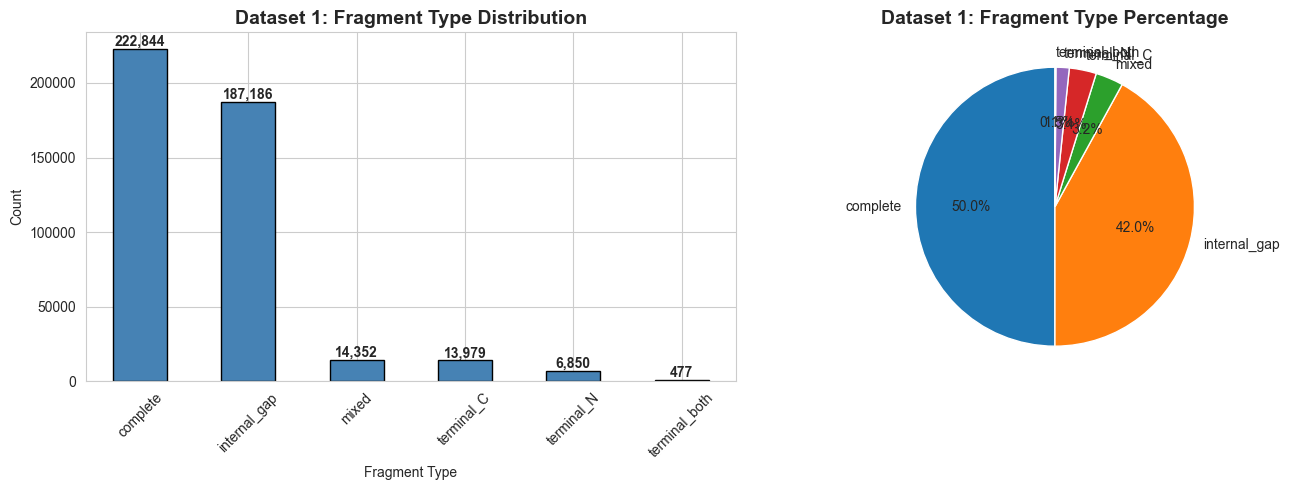

In [7]:
# Plot fragment type distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
fragment_counts = dataset1['fragment_type'].value_counts()
fragment_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Dataset 1: Fragment Type Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fragment Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add counts on bars
for i, (idx, val) in enumerate(fragment_counts.items()):
    ax1.text(i, val, f'{val:,}', ha='center', va='bottom', fontweight='bold')

# Percentage plot
fragment_pct = dataset1['fragment_type'].value_counts(normalize=True) * 100
ax2.pie(fragment_pct, labels=fragment_pct.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Dataset 1: Fragment Type Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset1_fragment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

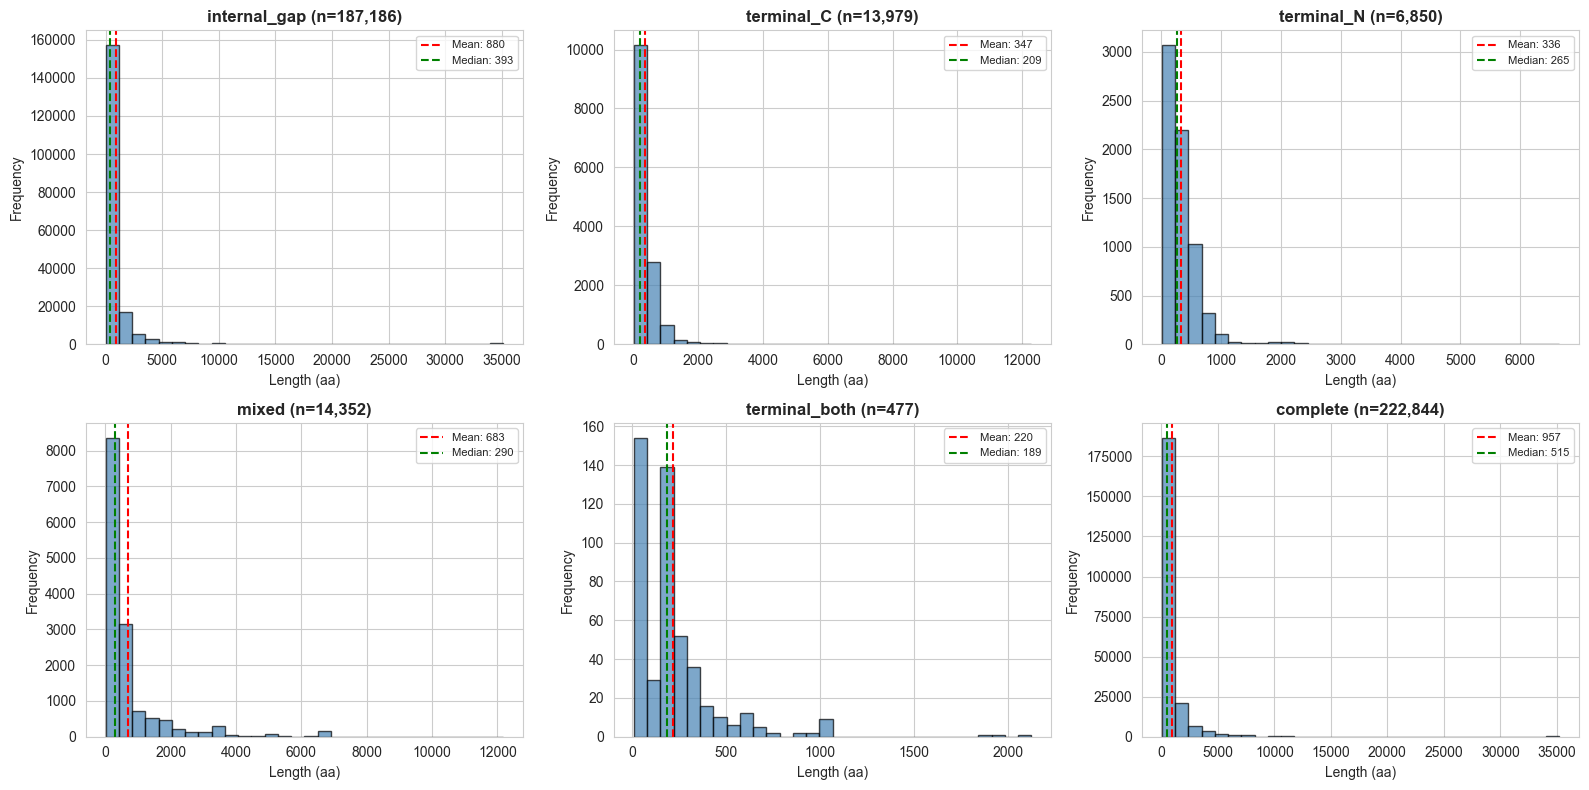

In [8]:
# Plot length distributions
fragment_types = dataset1['fragment_type'].unique()
n_types = len(fragment_types)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, ftype in enumerate(fragment_types):
    data = dataset1[dataset1['fragment_type'] == ftype]['sequence_length']
    axes[i].hist(data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.0f}')
    axes[i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.0f}')
    axes[i].set_title(f'{ftype} (n={len(data):,})', fontweight='bold')
    axes[i].set_xlabel('Length (aa)')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(fontsize=8)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('dataset1_length_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Save Dataset 1

In [9]:
# Shuffle the dataset
dataset1_shuffled = dataset1.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
output_file = 'dataset1_maximum_fragments.csv'
dataset1_shuffled.to_csv(output_file, index=False)

print(f"✓ Dataset 1 saved to '{output_file}'")
print(f"\nFinal Dataset 1 Summary:")
print("="*60)
print(f"Total sequences: {len(dataset1_shuffled):,}")
print(f"Fragments: {dataset1_shuffled['is_fragment'].sum():,}")
print(f"Complete: {(dataset1_shuffled['is_fragment'] == 0).sum():,}")
print(f"\nFile size: {dataset1_shuffled.memory_usage(deep=True).sum() / 1024**2:.2f} MB (in memory)")

✓ Dataset 1 saved to 'dataset1_maximum_fragments.csv'

Final Dataset 1 Summary:
Total sequences: 445,688
Fragments: 222,844
Complete: 222,844

File size: 475.08 MB (in memory)


In [10]:
# Show sample entries
print("\nSample entries from Dataset 1:")
print("="*80)
print(dataset1_shuffled[['source_accession', 'fragment_type', 'is_fragment', 
                         'sequence_length', 'removed_region']].head(20).to_string())


Sample entries from Dataset 1:
   source_accession fragment_type  is_fragment  sequence_length   removed_region
0            B1JUC0      complete            0              539                 
1            O42926      complete            0             3131                 
2            Q8RIH3  internal_gap            1              100             9-72
3            Q9JI20  internal_gap            1              678          125-191
4            B4M7T6      complete            0              783                 
5        A0A9E7LUR3  internal_gap            1               44           24-343
6            P50506  internal_gap            1               33           21-465
7            P22543      complete            0              875                 
8            P15089      complete            0              417                 
9            A0LTX2      complete            0              641                 
10           Q921G6      complete            0              680              

## 7. Summary

### Dataset 1 Characteristics:
- **Strategy**: Maximum data generation from domain annotations
- **Source**: All proteins with domain annotations from SwissProt
- **Generation**: Every possible fragment from each protein
- **Distribution**: Natural distribution based on domain annotation patterns
- **Pairs**: Each fragment paired with its complete source sequence

### Columns:
- `source_accession`: UniProt accession ID
- `fragment_type`: Type of fragment (terminal_N, terminal_C, terminal_both, internal_gap, mixed, complete)
- `sequence`: Amino acid sequence
- `is_fragment`: Binary flag (1=fragment, 0=complete)
- `sequence_length`: Length in amino acids
- `removed_region`: Position ranges removed (empty for complete)

### Next Steps:
**Dataset 2**: Augment with synthetic cuts to increase terminal_both coverage
**Dataset 3**: Distribution-matched, domain-agnostic random cuts